<a href="https://colab.research.google.com/github/Satvik256/TestRepo/blob/master/movielens_collab_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2020-06-01 08:02:14--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.53MB/s    in 0.8s    

2020-06-01 08:02:16 (5.53 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [3]:
!unzip /content/ml-100k

Archive:  /content/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
path=Path('/content/ml-100k')

In [0]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,names=['user_id','movie_id','rating','timestamp'])                     

In [6]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=['movie_id', 'title', 'date', 'N', 'url',*[f'g{i}' for i in range(19)]])
movies.head()

,movie_id,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [8]:
doc(pd.merge)

In [0]:
rating_movie=pd.merge(ratings,movies,how='inner',on=['movie_id'])

In [0]:
rating_movie=rating_movie[['user_id','movie_id','rating','timestamp','title']]

In [11]:
rating_movie.head()

,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data=CollabDataBunch.from_df(rating_movie,seed=42,valid_pct=0.1,item_name='title')

In [13]:
data.show_batch()

user_id,title,target
782,That Darn Cat! (1997),3.0
404,"Jackal, The (1997)",2.0
435,To Kill a Mockingbird (1962),3.0
294,"Boot, Das (1981)",5.0
303,Tombstone (1993),4.0


In [0]:
lrn=collab_learner(data,y_range=[0.,5.5],wd=1e-1,n_factors=35)

In [42]:
lrn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


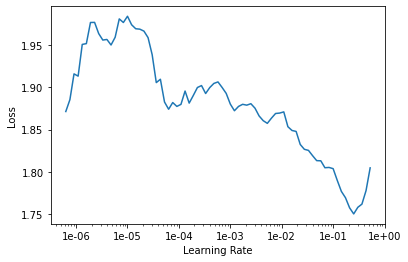

In [43]:
lrn.recorder.plot(skip_end=15)

In [44]:
lrn.fit_one_cycle(25,1e-3)

epoch,train_loss,valid_loss,time
0,1.790282,1.809514,00:09
1,1.578709,1.628952,00:09
2,1.178581,1.163961,00:09
3,0.923864,0.955661,00:09
4,0.890077,0.908680,00:09
5,0.835884,0.885113,00:09
6,0.823705,0.861181,00:09
7,0.789630,0.850749,00:09
8,0.760022,0.842536,00:09
9,0.748813,0.834402,00:09


In [0]:
lrn.save('model-1')

In [46]:
lrn.load('model-1')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
user_id 196; title Kolya (1996); ,user_id 63; title Kolya (1996); ,user_id 226; title Kolya (1996); ,user_id 154; title Kolya (1996); ,user_id 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
user_id 498; title Casino (1995); ,user_id 642; title Pocahontas (1995); ,user_id 58; title 2001: A Space Odyssey (1968); ,user_id 495; title Cat People (1982); ,user_id 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 35)
  (i_weight): Embedding(1654, 35)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.par

In [0]:
g=rating_movie.groupby('title')['rating'].count()

In [0]:
top_movies=g.sort_values(ascending=False).index.values[:1000]

In [0]:
movie_bias=lrn.bias(top_movies,is_item=True)

In [0]:
mean_ratings=rating_movie.groupby('title').mean()

In [0]:
movie_ratings = [(b, i, mean_ratings.loc[i].rating) for i,b in zip(top_movies,movie_bias)]

In [52]:
sorted(movie_ratings,key=lambda x:x[0],reverse=True)[:15]

[(tensor(0.4806), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4495), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.4487), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.4183), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4156), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4125), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.3961), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.3914), 'Apt Pupil (1998)', 4.1),
 (tensor(0.3802), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.3718), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.3701), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.3694), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.3651), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.3628), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.3604), 'Vertigo (1958)', 4.251396648044692)]

In [53]:
sorted(movie_ratings,key=lambda x:x[0])[:15]

[(tensor(-0.3375),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2676),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2505), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2326), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2249), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2031), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2030), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2025), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.1858), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.1765), 'Grease 2 (1982)', 2.0),
 (tensor(-0.1743), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.1713), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.1696), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.1693), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.1683), 'Showgirls (1995)', 1.

In [54]:
sorted(movie_ratings,key=lambda x:x[0]+x[2],reverse=True)[:15]

[(tensor(0.4806), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4495), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.3628), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.3701), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4125), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.3234), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.3068),
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (tensor(0.3651), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4183), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.3421), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4487), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.3802), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.3432), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.3694), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.2707), '12 Angry Men (1957)

In [0]:
movie_w=lrn.weight(top_movies,is_item=True)

In [56]:
print(movie_w.shape)
movie_w[0]

torch.Size([1000, 35])


tensor([-0.4429, -0.5112, -0.3017, -0.5129,  0.3194, -0.2655,  0.1704, -0.3745,
         0.3340, -0.7620, -0.4230, -0.0607,  0.4737, -0.1171, -0.4336,  0.5324,
        -0.1786,  0.3395, -0.3562, -0.5098, -0.3383, -0.6051,  0.0522,  0.1946,
        -0.1150, -0.6457, -0.1464, -0.2502, -0.4652,  0.6539,  0.1546,  0.1972,
         0.5759,  0.1359,  0.0038])

In [0]:
movie_pca=movie_w.pca(3)

In [58]:
movie_pca.shape

torch.Size([1000, 3])

In [0]:
f1,f2,f3=movie_pca.t()

In [60]:
movie_comp=[(x,i) for x,i in zip(f1,top_movies)]
sorted(movie_comp,key=lambda t:t[0],reverse=True)[:15]

[(tensor(1.3083), 'Home Alone 3 (1997)'),
 (tensor(1.2684), "McHale's Navy (1997)"),
 (tensor(1.2495), 'Jungle2Jungle (1997)'),
 (tensor(1.1942), 'Leave It to Beaver (1997)'),
 (tensor(1.1570), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1269), 'Congo (1995)'),
 (tensor(1.1237), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.1156), 'Bio-Dome (1996)'),
 (tensor(1.0968), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0159), 'Batman & Robin (1997)'),
 (tensor(1.0075), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(1.0050), 'Richie Rich (1994)'),
 (tensor(0.9901), 'Flipper (1996)'),
 (tensor(0.9897), 'Grease 2 (1982)'),
 (tensor(0.9872), 'Hellraiser: Bloodline (1996)')]

In [61]:
movie_comp=[(x,i) for x,i in zip(f1,top_movies)]
sorted(movie_comp,key=lambda t:t[0])[:15]

[(tensor(-1.0803), 'Casablanca (1942)'),
 (tensor(-1.0599), 'Godfather, The (1972)'),
 (tensor(-1.0422), 'Close Shave, A (1995)'),
 (tensor(-1.0394), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0044), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9730), 'Chinatown (1974)'),
 (tensor(-0.9529), 'Fargo (1996)'),
 (tensor(-0.9511),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9409), 'Citizen Kane (1941)'),
 (tensor(-0.9351), 'North by Northwest (1959)'),
 (tensor(-0.9254), 'Secrets & Lies (1996)'),
 (tensor(-0.9249), '12 Angry Men (1957)'),
 (tensor(-0.9191), 'Persuasion (1995)'),
 (tensor(-0.9081), 'Apocalypse Now (1979)'),
 (tensor(-0.9018), "One Flew Over the Cuckoo's Nest (1975)")]

In [62]:
movie_comp=[(x,i) for x,i in zip(f2,top_movies)]
sorted(movie_comp,key=lambda t:t[0],reverse=True)[:15]

[(tensor(0.8220), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7942), 'Trainspotting (1996)'),
 (tensor(0.7881), 'Clockwork Orange, A (1971)'),
 (tensor(0.7722), 'Brazil (1985)'),
 (tensor(0.7664), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7552), 'Keys to Tulsa (1997)'),
 (tensor(0.7452), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7384), 'Jude (1996)'),
 (tensor(0.7232), 'Cable Guy, The (1996)'),
 (tensor(0.7160), 'Big Night (1996)'),
 (tensor(0.7080), 'Serial Mom (1994)'),
 (tensor(0.6754), 'Crumb (1994)'),
 (tensor(0.6688), 'Showgirls (1995)'),
 (tensor(0.6667), 'Rosencrantz and Guildenstern Are Dead (1990)'),
 (tensor(0.6583), 'Sweet Hereafter, The (1997)')]

In [63]:
movie_comp=[(x,i) for x,i in zip(f2,top_movies)]
sorted(movie_comp,key=lambda t:t[0])[:15]

[(tensor(-1.1491), 'Braveheart (1995)'),
 (tensor(-1.1118), 'Titanic (1997)'),
 (tensor(-1.0885), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9216), "It's a Wonderful Life (1946)"),
 (tensor(-0.8969), 'Star Wars (1977)'),
 (tensor(-0.8882), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8807), 'Air Force One (1997)'),
 (tensor(-0.8623), 'American President, The (1995)'),
 (tensor(-0.8580), 'Return of the Jedi (1983)'),
 (tensor(-0.8451), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8414), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8399), 'Forrest Gump (1994)'),
 (tensor(-0.8377), 'Pretty Woman (1990)'),
 (tensor(-0.8194), 'Back to the Future (1985)'),
 (tensor(-0.7907), 'Top Gun (1986)')]

In [64]:
movie_comp=[(x,i) for x,i in zip(f3,top_movies)]
sorted(movie_comp,key=lambda t:t[0],reverse=True)[:15]

[(tensor(0.7733), 'Piano, The (1993)'),
 (tensor(0.7463), 'Crucible, The (1996)'),
 (tensor(0.6569), "Breakfast at Tiffany's (1961)"),
 (tensor(0.6146), 'Cinema Paradiso (1988)'),
 (tensor(0.5978), 'My Fair Lady (1964)'),
 (tensor(0.5893), 'Dirty Dancing (1987)'),
 (tensor(0.5880), 'Emma (1996)'),
 (tensor(0.5878), 'All About Eve (1950)'),
 (tensor(0.5784), 'Little Women (1994)'),
 (tensor(0.5595), 'Room with a View, A (1986)'),
 (tensor(0.5525), 'Evita (1996)'),
 (tensor(0.5423), 'Sound of Music, The (1965)'),
 (tensor(0.5400), 'To Kill a Mockingbird (1962)'),
 (tensor(0.5397), 'English Patient, The (1996)'),
 (tensor(0.5267), 'Bridges of Madison County, The (1995)')]

In [65]:
movie_comp=[(x,i) for x,i in zip(f3,top_movies)]
sorted(movie_comp,key=lambda t:t[0])[:15]

[(tensor(-1.0454), 'Terminator, The (1984)'),
 (tensor(-0.8581), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.8062), 'Reservoir Dogs (1992)'),
 (tensor(-0.7756), 'Scream (1996)'),
 (tensor(-0.7627), 'Star Wars (1977)'),
 (tensor(-0.7426), 'Terminator 2: Judgment Day (1991)'),
 (tensor(-0.7341), 'Starship Troopers (1997)'),
 (tensor(-0.7338), 'Clerks (1994)'),
 (tensor(-0.7284), 'Empire Strikes Back, The (1980)'),
 (tensor(-0.7249), 'Event Horizon (1997)'),
 (tensor(-0.6842), 'Rock, The (1996)'),
 (tensor(-0.6745), 'Game, The (1997)'),
 (tensor(-0.6353), 'Die Hard (1988)'),
 (tensor(-0.6226), 'Crow, The (1994)'),
 (tensor(-0.6161), 'Die Hard: With a Vengeance (1995)')]

In [0]:
import seaborn as sns

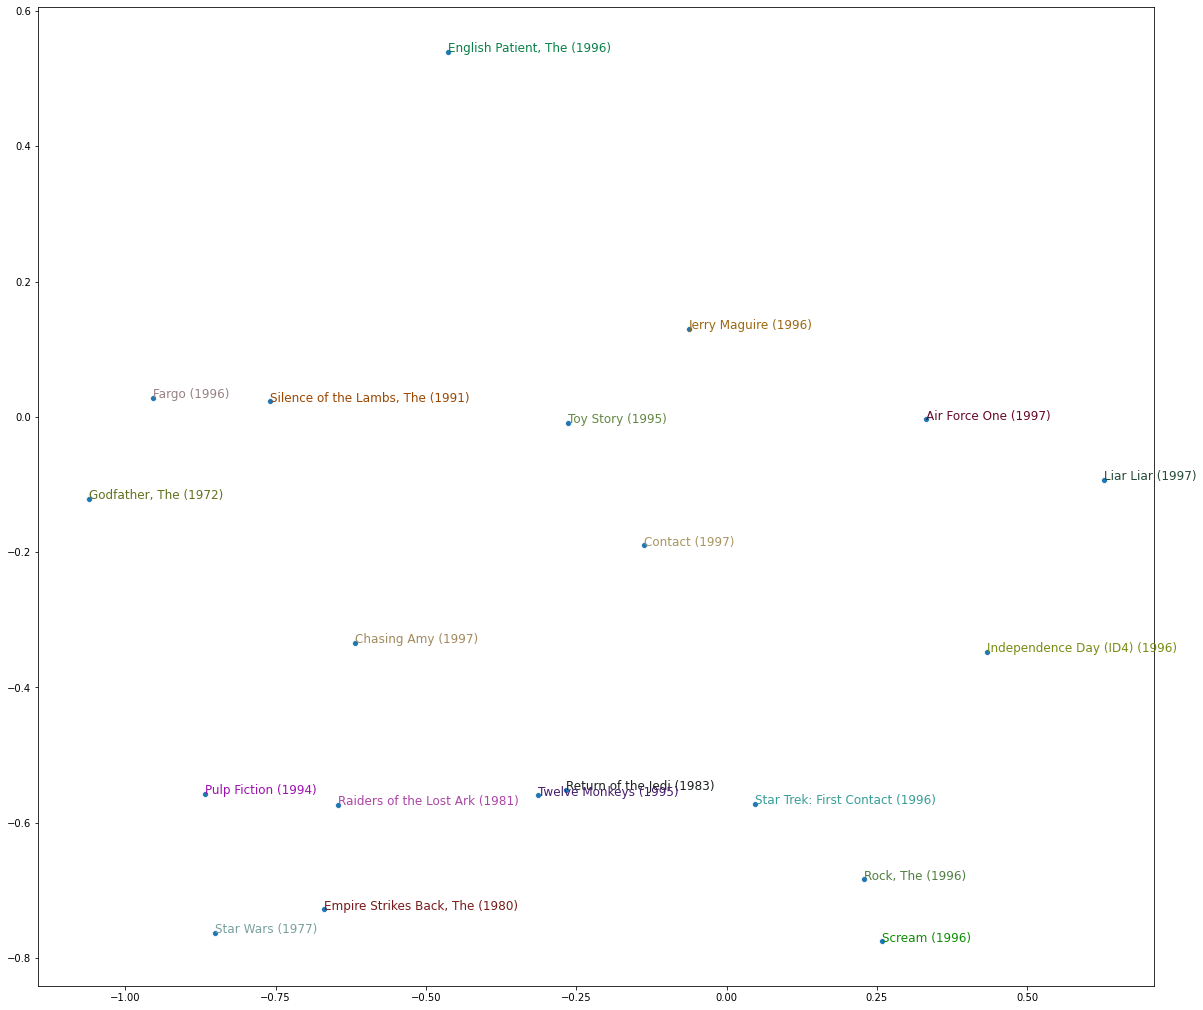

In [67]:
# idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(20))
X = f1[idxs]
Y = f3[idxs]
plt.figure(figsize=(20,18))
sns.scatterplot(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
     plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=12)
plt.show()